In [3]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 

import SessionTools.two_photon as st2p

In [4]:
data_directory = 'LineScan-04082025-1336-fly3-025'

basedir = pathlib.PurePath(f'/Users/lilynguyen/Downloads/{data_directory}')
basename_input = pathlib.Path(basedir.joinpath(data_directory))
metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)

In [5]:
tiff_data = st2p.preprocessing_tools.tiff_tools.read_linescan(basename_input, metadata['linescan_size'])

(2, 3, 8192, 206)


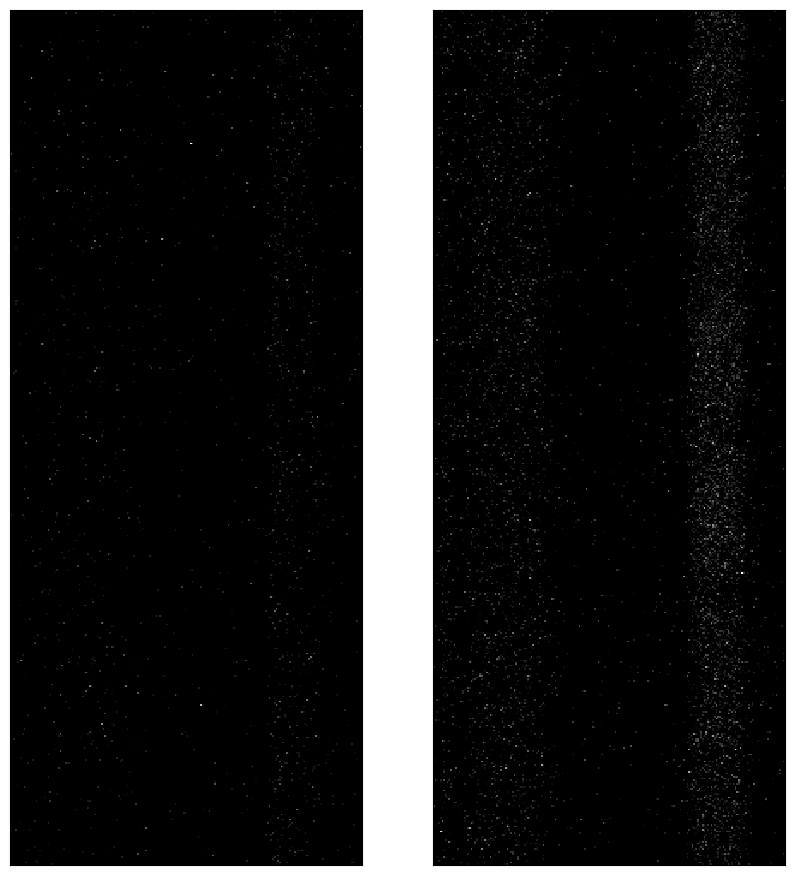

In [6]:
# plot first 500 lines from each channel
fig, ax = plt.subplots(1, len(tiff_data.keys()), figsize=(10,20))

for i, c in enumerate(tiff_data.keys()):
    ax[i].imshow(tiff_data[c][0:500], cmap='Greys_r', interpolation='nearest')
    ax[i].set_yticks([])
    ax[i].set_xticks([])

In [7]:
# function for getting the mean across y values
def get_mean_f(np_arrays):
    return np.mean(np_arrays, axis=0)

In [8]:
asap_array = tiff_data['Ch2']

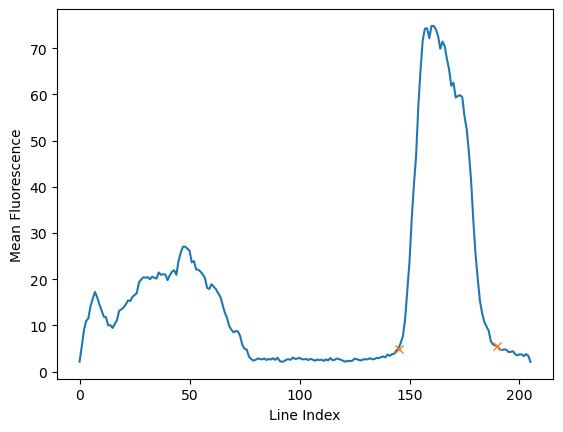

In [ ]:
# average fluorescence from all line scans and plot to find glomeruli area
mean_f = get_mean_f(asap_array)

plt.plot(range(len(mean_f)), mean_f)
plt.plot([145, 190], mean_f[[145, 190]], "x")
plt.ylabel('Mean Fluorescence')
plt.xlabel('Line Index')
plt.show()

In [14]:
glom_start = 145
glom_end = 190


not_glom_start = 100
not_glom_end = 145

In [23]:
# create an array with the average fluorescence of the ROI during each line scan
glom_fluor = []
for idx, y in enumerate(asap_array):
    glom_fluor.append(asap_array[idx][glom_start:glom_end].mean()) # could make for loop to iterate through multiple ROIs
glom_fluor = np.array(glom_fluor)

In [24]:
not_glom_fluor = []
for idx, y in enumerate(asap_array):
    not_glom_fluor.append(asap_array[idx][not_glom_start:not_glom_end].mean()) # could make for loop to iterate through multiple ROIs
not_glom_fluor = np.array(not_glom_fluor)

In [ ]:
glom_fluor_corr = glom_fluor - not_glom_fluor

18408

In [10]:
metadata['linescan_size']

{'frames': 3,
 'channels': 2,
 'y_px_frame': 8192,
 'x_px_line': 206,
 'y_px_last_frame': 2025,
 'scan_line_period': 0.0032592}

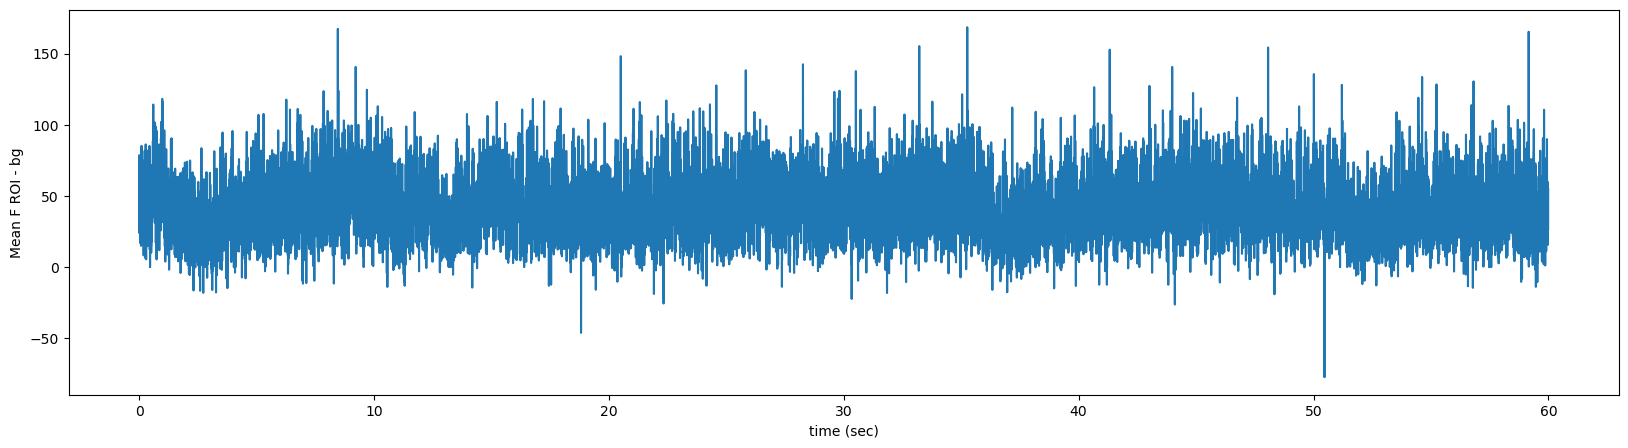

In [ ]:
# plot raw fluorescence
end_time = ((metadata['linescan_size']['y_px_frame'] * metadata['linescan_size']['frames']) - (metadata['linescan_size']['y_px_frame'] - metadata['linescan_size']['y_px_last_frame'])) * metadata['linescan_size']['scan_line_period']
time = np.arange(0, end_time, metadata['linescan_size']['scan_line_period'])

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], glom_fluor_corr)
plt.ylabel('Mean F ROI - bg')
plt.xlabel('time (sec)')
plt.show()

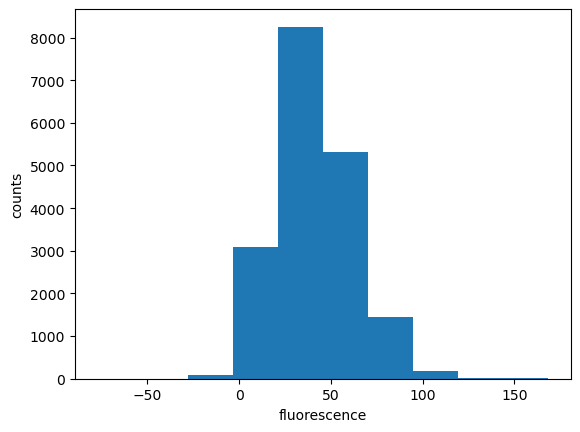

In [31]:
# plot fluorescence distribution
plt.hist(glom_fluor_corr)
plt.ylabel('counts')
plt.xlabel('fluorescence')
plt.show()

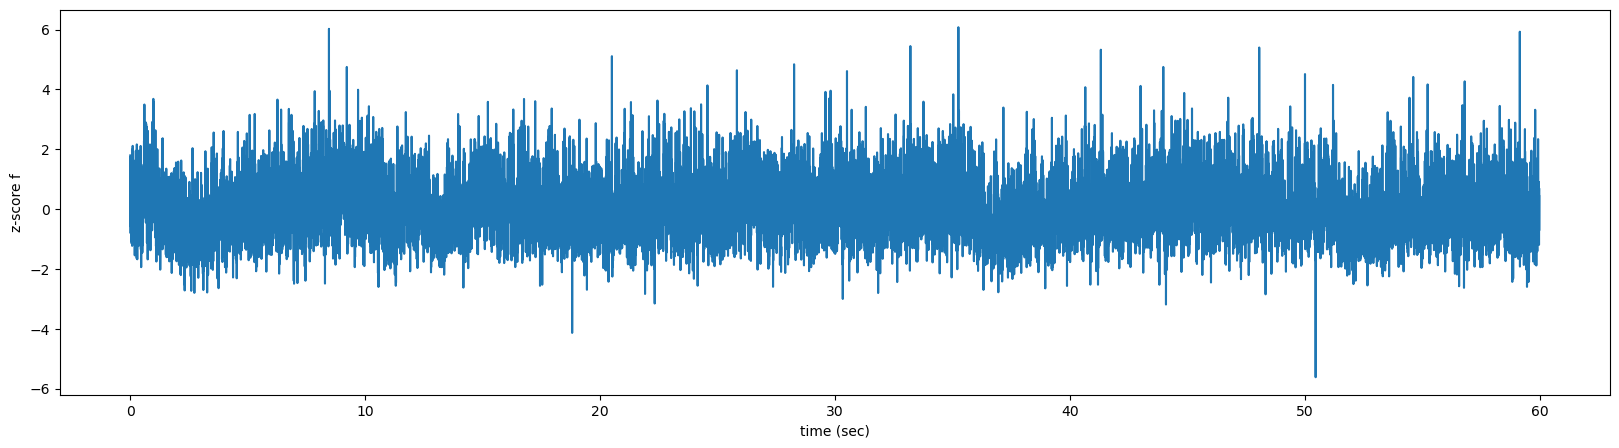

In [37]:
# z-scored fluorescence
dff_glom = sp.stats.zscore(glom_fluor_corr)

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], dff_glom)
plt.ylabel('z-score f')
plt.xlabel('time (sec)')
plt.show()

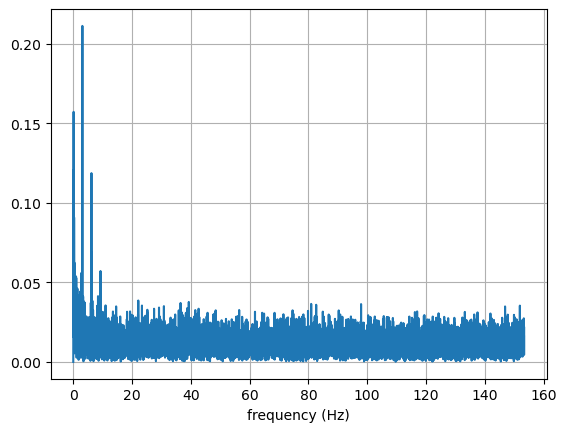

In [42]:
# plot frequencies
from scipy.fft import fft, fftfreq
# Number of sample points
N = len(dff_glom)
# sample spacing
T = metadata['linescan_size']['scan_line_period']
x = time[0:-1]
y = dff_glom
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.xlim(0, 50)
plt.xlabel('frequency (Hz)')
plt.grid()
plt.show()

In [43]:
# low pass from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, fs, order=5):
    return sp.signal.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.signal.lfilter(b, a, data)
    return y

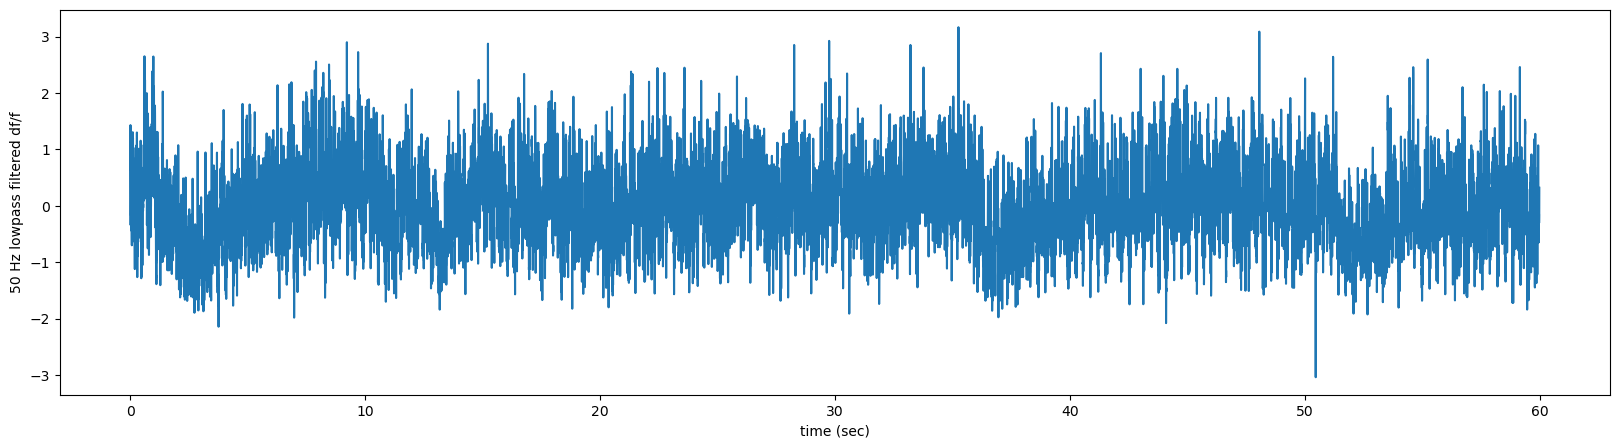

In [45]:
# lowpass filter data
cutoff = 50 # Hz
lowpass = butter_lowpass_filter(dff_glom, cutoff, 1/metadata['linescan_size']['scan_line_period'], 1)

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], lowpass)
plt.xlabel('time (sec)')
plt.ylabel(f'{cutoff} Hz lowpass filtered df/f')
plt.show()